Part 3 - Running the Simulation
===============================

We have completed all the necessary steps to run the Monte Carlo simulations:
- Created the `DualEnergyCTGroup` (the variable `dectgroup`).
- Imported the original CT scans for low and high energies.
- Created a segmentation voxel image (optional, to use calibration materials as a quality control; could also be imported from elsewhere).
- Created a mask voxel image (optional, to tell RockVerse which voxels to ignore in the Monte Carlo inversion; could also be imported from elsewhere).
- Populated necessary information for the calibration materials.
- Pre-calculated the set of inversion coefficients.

We can now call the `run` method to perform the full inversion. 

Remember: we are performing Monte Carlo in the Digital Rock universe! This process is computationally intensive and is designed to run in a high-performance computing environment, such as a GPU-enabled machine or a handful of nodes in a CPU cluster. This ensures efficiency when processing large datasets.

## Running in Command Line Mode

To run in command line mode, save a file, say `run.py`, with the following content:

```python
import rockverse as rv
dectgroup = rv.open(r'/path/to/dual_energy_ct/C04B21')
dectgroup.run()
```

and call Python with your MPI executable to run the file, e.g.:

```bash
$ mpirun -N 256 python run.py
```

or submit it as a batch script to your job scheduler, such as Slurm:

```bash
#!/bin/bash
#SBATCH -J awesome_job_name
#SBATCH --nodes=2
#SBATCH --partition <your_partition>
#SBATCH --gres=gpu:16
#SBATCH --ntasks-per-node=256
#SBATCH --output=outputlog
#SBATCH --chdir=/path/to/workdir

conda activate you_environment_with_rockverse
mpirun python3 ./run.py 
```

## Running in Jupyter with Ipyparallel

Here we'll use again a machine with 8 NVIDIA Tesla V100-SXM2-32GB GPUs, and therefore we can use 
Ipyparallel to create a cluster with 8 MPI processes, that will distribute the workload among 
the 8 GPUS. Let's create the cluster:

In [1]:
import ipyparallel as ipp

# Create an MPI cluster with 8 engines
cluster = ipp.Cluster(engines="mpi", n=8)

# Start and connect to the cluster
rc = cluster.start_and_connect_sync()

# Enable IPython magics for parallel processing
rc[:].activate()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

Now we use the ``%%px`` magic to send the work to this parallel kernel:

In [ ]:
%%px --block

import rockverse as rv

# Open the group
dectgroup = rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX')

# Call the run method to perform the calculations
dectgroup.run()

%px:   0%|          | 0/8 [00:00<?, ?tasks/s]

[stdout:0] [2025-02-25 14:13:51] Hashing Low energy attenuation: 100% 16/16 [00:00<00:00, 48.74chunk/s]
[2025-02-25 14:13:52] Hashing High energy attenuation: 100% 16/16 [00:00<00:00, 51.31chunk/s]
[2025-02-25 14:13:52] Hashing mask: 100% 16/16 [00:00<00:00, 204.28chunk/s]
[2025-02-25 14:13:52] Hashing segmentation: 100% 16/16 [00:00<00:00, 192.98chunk/s]
[2025-02-25 14:13:52] Calibration matrices up to date.
[2025-02-25 14:13:53] Creating output images: 100% 11/11 [00:01<00:00,  6.69it/s]
[2025-02-25 14:13:56] Counting voxels: 100% 16/16 [00:04<00:00,  3.98chunk/s]
[2025-02-25 14:14:00] rho/Z inversion (chunk 16/16): 100% 39445817/39445817 [37:17:05<00:00, 293.88voxel/s]


## Visualization

After completion, you will have access to the Monte Carlo results through the
following new voxel images as attributes of dectgroup:

- ``rho_min``: Voxel image with the minimum electron density per voxel.
- ``rho_p25``: Voxel image with the the first quartile for the electron density per voxel.
- ``rho_p50``: Voxel image with the the median values for the electron density per voxel.
- ``rho_p75``: Voxel image with the the third quartile for the electron density per voxel.
- ``rho_max``: Voxel image with the maximum electron density per voxel.
- ``Z_min``: Voxel image with the minimum effective atomic number per voxel.
- ``Z_p25``: Voxel image with the the first quartile for the effective atomic number per voxel.
- ``Z_p50``: Voxel image with the the median values for the effective atomic number per voxel.
- ``Z_p75``: Voxel image with the the third quartile for the effective atomic number per voxel.
- ``Z_max``: Voxel image with the maximum effective atomic number per voxel.
- ``valid``: Voxel image with the number of valid Monte Carlo results for each voxel.

[2025-02-27 11:49:24] Histogram rho_p50 (min/max): 100%|>>>>>>>>>>| 16/16 [00:04<00:00,  3.38chunk/s]
[2025-02-27 11:49:28] Histogram rho_p50 (reading segmentation): 100%|>>>>>>>>>>| 16/16 [00:00<00:00, 60.97chunk/s]
[2025-02-27 11:49:29] Histogram rho_p50 (counting voxels): 100%|>>>>>>>>>>| 16/16 [00:05<00:00,  2.91chunk/s]
[2025-02-27 11:49:36] Histogram Z_p50 (min/max): 100%|>>>>>>>>>>| 16/16 [00:04<00:00,  3.40chunk/s]
[2025-02-27 11:49:41] Histogram Z_p50 (reading segmentation): 100%|>>>>>>>>>>| 16/16 [00:00<00:00, 61.04chunk/s]
[2025-02-27 11:49:41] Histogram Z_p50 (counting voxels): 100%|>>>>>>>>>>| 16/16 [00:09<00:00,  1.73chunk/s]


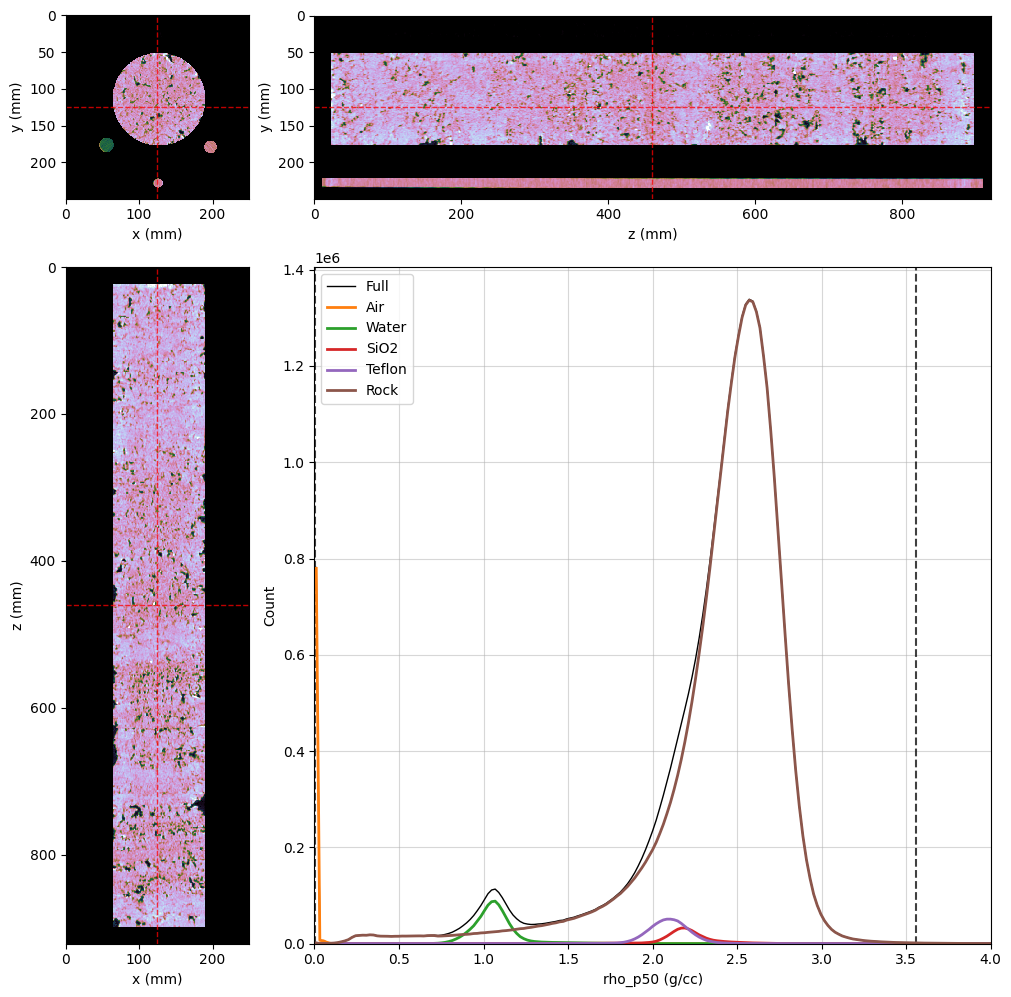

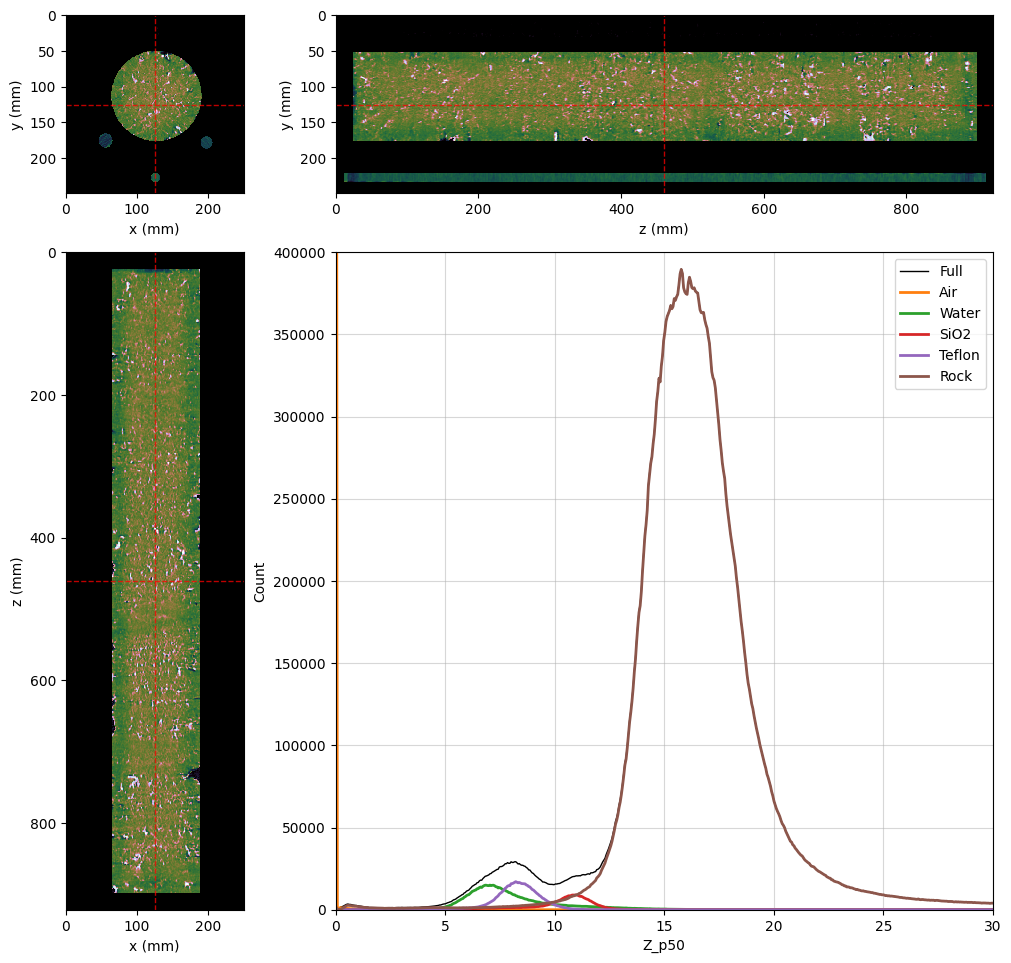

In [18]:
# Running locally (no %%px magic)

import rockverse as rv
dectgroup = rv.open('/estgf_dados/P_D/GOB7/testemunhos/C04B21_DGX')

rho_p50_viewer = rv.OrthogonalViewer(
    image=dectgroup.rho_p50,
    segmentation=dectgroup.segmentation,
    segmentation_alpha=0,
    mask=dectgroup.mask,
    histogram_bins=1000,
    image_dict={'cmap': 'cubehelix'}
)
rho_p50_viewer.ax_histogram.set_xlim(0, 4)


Z_p50_viewer = rv.OrthogonalViewer(
    image=dectgroup.Z_p50,
    segmentation=dectgroup.segmentation,
    segmentation_alpha=0,
    mask=dectgroup.mask,
    histogram_bins=1000,
    image_dict={'cmap': 'cubehelix'}
)
Z_p50_viewer.ax_histogram.set_xlim(0, 30)
Z_p50_viewer.ax_histogram.set_ylim(0, 4e5)


for viewer in (rho_p50_viewer, Z_p50_viewer):
    viewer.figure.set_size_inches(10, 10)
    viewer.ax_histogram.legend(
        [
            viewer.histogram_lines['full'],
            viewer.histogram_lines['1'],
            viewer.histogram_lines['2'],
            viewer.histogram_lines['3'],
            viewer.histogram_lines['4'],
            viewer.histogram_lines['5'],
        ], [
            'Full',
            'Air',
            'Water',
            'SiO2',
            'Teflon',
            'Rock'
        ]
    )


Let's built a boxplot to show all the inversion values at the orthogonal viewers' referece point:

Text(0.5, 0, 'Effective atomic number')

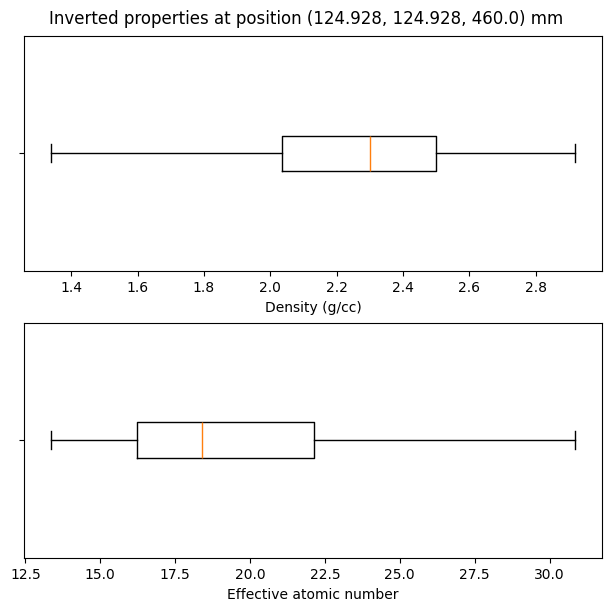

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, layout='constrained')
fig.set_size_inches(6, 6)

# Get the reference voxel in the orthogonal viewer
ref_voxel = rho_p50_viewer.ref_voxel
ref_point = rho_p50_viewer.ref_point
fig.suptitle(f"Inverted properties at position {ref_point} {dectgroup.lowECT.voxel_unit}")

box_rho = [{
        'label' : "",
        'whislo': dectgroup.rho_min[ref_voxel],    # Bottom whisker position
        'q1'    : dectgroup.rho_p25[ref_voxel],    # First quartile (25th percentile)
        'med'   : dectgroup.rho_p50[ref_voxel],    # Median         (50th percentile)
        'q3'    : dectgroup.rho_p75[ref_voxel],    # Third quartile (75th percentile)
        'whishi': dectgroup.rho_max[ref_voxel],    # Top whisker position
        'fliers': []                               # Outliers are not kept by the inversion
    }]

ax[0].bxp(box_rho, showfliers=False, vert=False)
ax[0].set_xlabel('Density (g/cc)')

box_Z = [{
        'label' : "",
        'whislo': dectgroup.Z_min[ref_voxel],    # Bottom whisker position
        'q1'    : dectgroup.Z_p25[ref_voxel],    # First quartile (25th percentile)
        'med'   : dectgroup.Z_p50[ref_voxel],    # Median         (50th percentile)
        'q3'    : dectgroup.Z_p75[ref_voxel],    # Third quartile (75th percentile)
        'whishi': dectgroup.Z_max[ref_voxel],    # Top whisker position
        'fliers': []                             # Outliers are not kept by the inversion
    }]
ax[1].bxp(box_Z, showfliers=False, vert=False)
ax[1].set_xlabel('Effective atomic number')
